In [34]:
# For today's session we will use a new Astronomy / Space related Python package called skyfield
# The package is listed in the requirements.txt, but you can also install it here in a notebook
# by typing
# >>> !pip install skyfield
import skyfield
import skyfield.api
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos as skyfield_hipparcos
from skyfield.data import mpc as skyfield_mpc
from skyfield.data import stellarium as skyfield_stellarium
from skyfield.projections import build_stereographic_projection as skyfield_build_stereographic_projection

In [35]:
# Standard libraries
import datetime

# Installed libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [36]:
# Skyfield has it's own datetime format. Let's create a list with 11 days that we'll use to compute
# the comet's position
comet_ini_datetime = datetime.datetime(year=2023, month=1, day=29, tzinfo=datetime.timezone.utc)
comet_datetime_list = [comet_ini_datetime + datetime.timedelta(days=k) for k in range(11)]

# Now we need the skyfield timescale to convert it to Ephemeris Time (similar to SPICE)
timescale = skyfield.api.load.timescale()
comet_timesteps = timescale.from_datetimes(comet_datetime_list)

In [37]:
# Additionally, we need the Sun's and Earth's information
generic_spk_kernel = skyfield.api.load_file("../../kernels/spk/de432s.bsp")

# Compared to SPICE this is more "human readable"
sun = generic_spk_kernel["sun"]
earth = generic_spk_kernel["earth"]

In [38]:
# Comet data from MPC
with skyfield.api.load.open(skyfield_mpc.COMET_URL) as _obj:
    comets_df = skyfield_mpc.load_comets_dataframe(_obj)
    
# Stars from the Hipparcos catalogue
with skyfield.api.load.open(skyfield_hipparcos.URL) as _obj:
    stars_df = skyfield_hipparcos.load_dataframe(_obj)
    
# Now the constellation lines
# Note: Currently (29th Jan. 2023), the Stellarium related functions in skyfield cannot handle
# somehow the current Stellarium data. I created an extraction and stored it in this repository to
# load
with open("constellations.txt", "rb") as _obj:
    constellations_list = skyfield.data.stellarium.parse_constellations(_obj)

In [39]:
# How does the comet dataframe look like?
comets_df

,perihelion_year,perihelion_month,perihelion_day,perihelion_distance_au,eccentricity,argument_of_perihelion_degrees,longitude_of_ascending_node_degrees,inclination_degrees,magnitude_g,magnitude_k,designation,reference
0,2026,6,15.6466,2.587016,0.314298,333.4822,40.0471,2.5991,11.5,4.0,P/1996 R2 (Lagerkvist),NK 1615
1,2027,9,7.7477,3.419544,0.243607,244.8716,159.0421,5.0291,13.0,2.0,P/1998 VS24 (LINEAR),MPC 75703
2,2025,10,30.2992,1.122827,0.672196,231.3520,137.8425,7.5670,20.0,2.0,P/1999 RO28 (LONEOS),NK 731
3,2025,12,21.8201,3.297794,0.211429,161.6264,285.2435,5.0297,13.5,2.0,P/1999 XN120 (Catalina),MPC 75704
4,2025,12,2.2988,1.628150,0.530646,176.5825,160.2727,11.6788,18.0,4.0,P/2000 R2 (LINEAR),NK 744
...,...,...,...,...,...,...,...,...,...,...,...,...
1186,2025,2,15.3542,2.075189,0.630559,32.4119,40.3801,10.4373,17.5,4.0,497P/Spacewatch-PANSTARRS,MPEC 2025-A40
1187,2024,12,18.9218,1.964332,0.572379,179.0830,279.2308,14.4827,14.7,4.0,498P/LINEAR,MPEC 2025-GB9
1188,2025,3,4.3912,0.931036,0.691457,2.5537,139.3100,24.5824,18.5,4.0,499P/Catalina,MPEC 2025-GB9
1189,2017,9,9.4886,0.255240,1.199252,241.6845,24.5997,122.6778,23.0,2.0,1I/`Oumuamua,MPC107687


In [40]:
# How does the stars dataframe look like?
stars_df

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year
hip,,,,,,,,
1,9.10,0.000912,1.089013,3.54,-5.20,-1.88,0.000061,1991.25
2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,0.000253,1991.25
3,6.61,0.005008,38.859286,2.81,5.24,-2.91,0.000334,1991.25
4,8.06,0.008382,-51.893546,7.75,62.85,0.16,0.000559,1991.25
5,8.55,0.009965,-40.591224,2.87,2.53,9.07,0.000664,1991.25
...,...,...,...,...,...,...,...,...
118318,6.99,359.963744,11.673709,1.92,-2.16,2.09,23.997583,1991.25
118319,8.23,359.973913,-22.428180,10.63,148.74,27.53,23.998261,1991.25
118320,7.59,359.976057,5.956638,5.00,20.92,-35.26,23.998404,1991.25


In [41]:
# ... and the constellation list:
print(constellations_list[0])

('And', [(7607, 4436), (4436, 2912), (2912, 677), (677, 3092), (3092, 5447), (5447, 9640), (4436, 5447), (3693, 3092), (3092, 2912), (2912, 1473), (1473, 1366), (1366, 1686), (1686, 1473)])


In [42]:
# Extract the comet C/2022 E3
comet_row = comets_df.loc[comets_df["designation"].str.contains("C/2022 E3")].squeeze()

# Similar like SPICE: we need to set the orbit w.r.t. a center object. Here: the Sun
comet = sun + skyfield.data.mpc.comet_orbit(comet_row, timescale, GM_SUN)

In [43]:
# Now we parse the constellation information
edges = [edge for name, edges in constellations_list for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

In [44]:
# Now we extract the stars' position as seen from Earth for a particular time and compute their
# positions w.r.t. a set projection
star_positions = earth.at(comet_timesteps[5]).observe(skyfield.api.Star.from_dataframe(stars_df))

# In between we can set a center for our projection. Here: the middle of our comet time list
center = earth.at(comet_timesteps[5]).observe(comet)
projection = skyfield_build_stereographic_projection(center)

stars_df['x'], stars_df['y'] = projection(star_positions)

# Do the same thing with the comet!
comet_x, comet_y = projection(earth.at(comet_timesteps).observe(comet))

In [45]:
# Now set the field of view in degrees and the limiting magnitude
FOV_deg = 90.0
lim_mag = 6

# Apply the limiting magnitude
stars_df.loc[:, "visible"] = stars_df["magnitude"].apply(lambda x: 1 if x<=lim_mag else 0)
stars_df.loc[:, "plot_size"] = stars_df["magnitude"].apply(lambda x: (1.0 + lim_mag - x)**2.0)

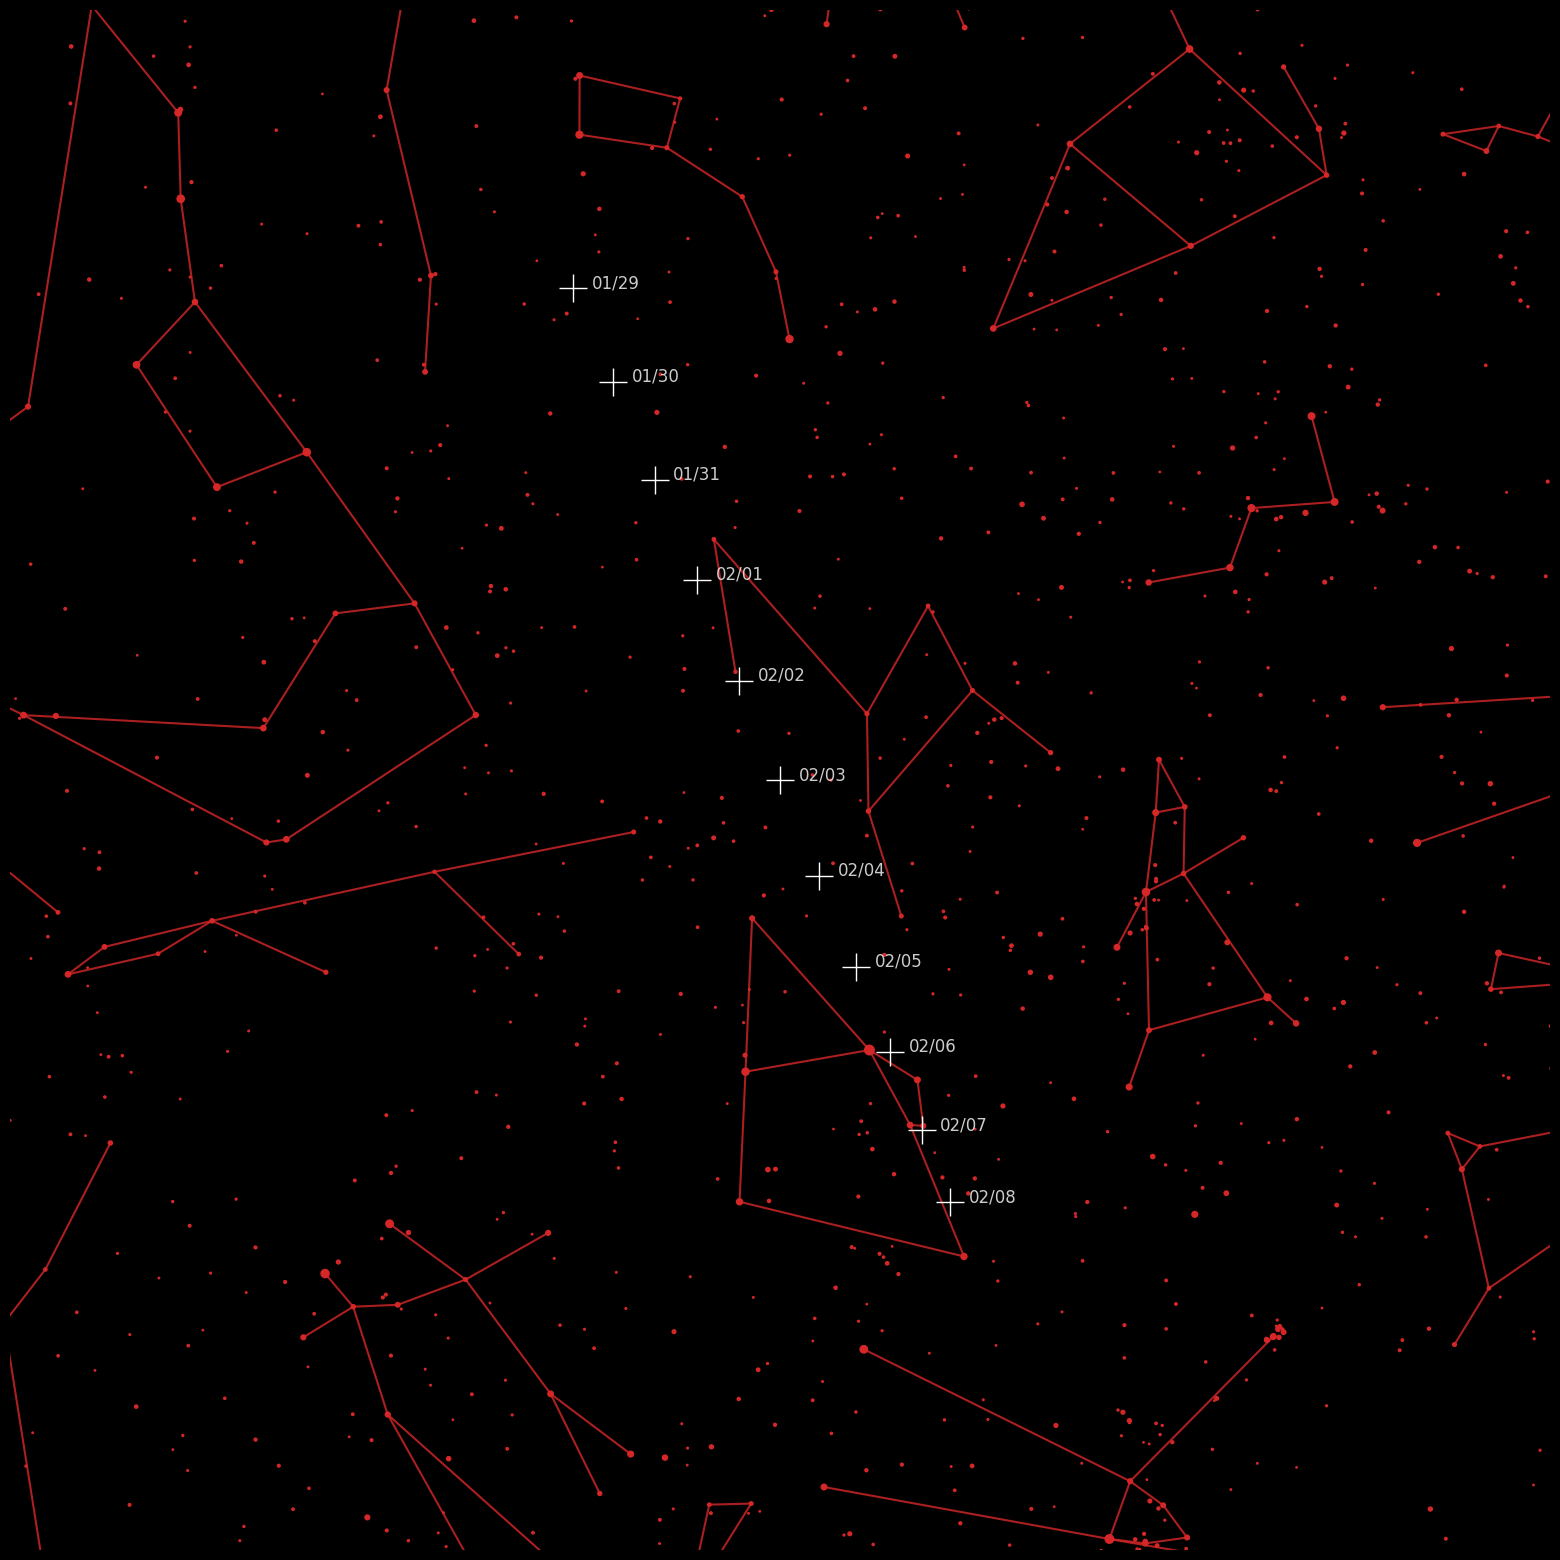

In [46]:
# Time to build the figure!
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=[20, 20])

# Add the stars
ax.scatter(stars_df.loc[stars_df["visible"]==1]["x"],
           stars_df.loc[stars_df["visible"]==1]["y"],
           s=stars_df.loc[stars_df["visible"]==1]["plot_size"],
           color="tab:red")

# Add the constellations
xy1 = stars_df[["x", "y"]].loc[edges_star1].values
xy2 = stars_df[["x", "y"]].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)
ax.add_collection(matplotlib.collections.LineCollection(lines_xy, colors="tab:red", alpha=.8))

# Add the comet
ax.plot(comet_x,
        comet_y,
        marker='+',
        markersize=20,
        lw=0,
        c="white")

# Set the dates
for _x, _y, _date in zip(comet_x, comet_y, comet_timesteps.utc_strftime('%m/%d')):
    comet_date_text = ax.text(_x + 0.01,
                              _y - 0.00,
                              _date,
                              color="white",
                              fontsize=12)
    comet_date_text.set_alpha(0.8)

# More parameters
angle = np.pi - FOV_deg / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)

# Remove Frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)